# Project 5B: Flow Matching from Scratch!

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [2]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

## Neural Network Resources

In this part, you will build and train a [UNet](https://arxiv.org/abs/1505.04597), which is more complex than the MLP you implemented in the NeRF project.  We provide all class definitions you may need (but feel free to add or modify them as necessary).  

Instead of asking ChatGPT to write everything for you, please consult the following resources when you get stuck — they will help you understand how and why things work under the hood.

- PyTorch Documentation — [`Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`ConvTranspose2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), and [`AvgPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
- PyTorch Documentation - [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), the dataset we gonna use, and [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html), the off-the-shell dataloader we can directly use.
- PyTorch [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) on how to train a classifier on CIFAR10 dataset. The structure of your training code will be very similar to this one.

# Part 1: Training a Single-step Denoising UNet


# Part 1.1: Implementing the UNet

## Implementing Simple and Composed Ops

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.conv(x)
        f = self.bn(f)
        f = self.gelu(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.conv(x)
        f = self.bn(f)
        f = self.gelu(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv_up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.conv_up(x)
        f = self.bn(f)
        f = self.gelu(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        # ===== your code here! ====
        self.pool = nn.AvgPool2d(7)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.pool(x)
        f = self.gelu(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv_unflat = nn.ConvTranspose2d(in_channels, in_channels, 7, 7, 0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.conv_unflat(x)
        f = self.bn(f)
        f = self.gelu(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv_1 = Conv(in_channels, out_channels)
        self.conv_2 = Conv(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.conv_1(x)
        f = self.conv_2(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.downConv1 = DownConv(in_channels, out_channels)
        self.Conv2 = Conv(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.downConv1(x)
        f = self.Conv2(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.upConv1 = UpConv(in_channels, out_channels)
        self.Conv2 = Conv(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f = self.upConv1(x)
        f = self.Conv2(f)
        return f
        # ===== end of code ====
        raise NotImplementedError()

## Implementing Unconditional UNet

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        self.convBlock_1 = ConvBlock(in_channels, num_hiddens)
        self.downblock_1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock_2 = DownBlock(num_hiddens, 2 * num_hiddens)

        self.flatten = Flatten()
        self.unflatten = Unflatten(2 * num_hiddens)

        self.upblock_1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.upblock_2 = UpBlock(2 * num_hiddens, num_hiddens)

        self.convBlock_2 = ConvBlock(2 * num_hiddens, num_hiddens)
        self.lastConv = nn.Conv2d(num_hiddens, in_channels, 3, 1, 1)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        f1 = self.convBlock_1(x)
        #print(f"f1 shape: {f1.shape}")
        
        f2 = self.downblock_1(f1)
        #print(f"f2 shape: {f2.shape}")
        
        f3 = self.downblock_2(f2)
        #print(f"f3 shape: {f3.shape}")

        f4 = self.flatten(f3)
        #print(f"f4 shape: {f4.shape}")
        
        f5 = self.unflatten(f4)
        #print(f"f5 shape: {f5.shape}")

        concat_bottom = torch.cat((f3, f5), dim=1)
        #print(f"concat_bottom shape: {concat_bottom.shape}")
        
        f6 = self.upblock_1(concat_bottom)
        #print(f"f6 shape: {f6.shape}")
        
        concat_second = torch.cat((f2, f6), dim=1)
        #print(f"concat_second shape: {concat_second.shape}")
        
        f7 = self.upblock_2(concat_second)
        #print(f"f7 shape: {f7.shape}")

        concat_last = torch.cat((f1, f7), dim = 1)
        #print(f"concat_last shape: {concat_last.shape}")
        
        f8 = self.convBlock_2(concat_last)
        #print(f"f8 shape: {f8.shape}")

        final = self.lastConv(f8)
        #print(f"final shape: {final.shape}")
        return final

        # ===== end of code ====
        raise NotImplementedError()

# Part 1.2: Using the UNet to Train a Denoiser

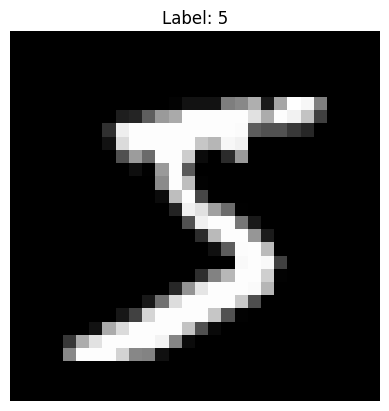

tensor(1.)


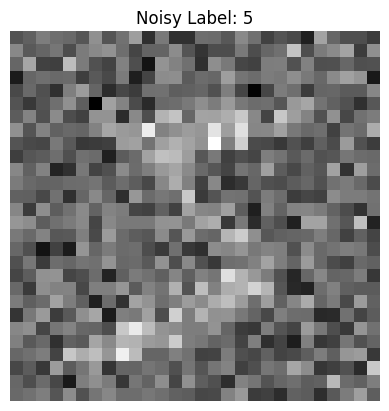

In [5]:
# Visualize images at different noisy level
transform = ToTensor()
train_dataset = MNIST(root='./data', train=True, download=False, transform=transform)
# ===== your code here! ====
x,y = train_dataset[0]
plt.imshow(x.squeeze(0), cmap="gray")
plt.title(f"Label: {y}")
plt.axis("off")
plt.show()

print(x.max())

def add_noise(x, sigma):
    noise = torch.randn_like(x) * sigma  # same shape as x
    noisy = x + noise
    return noisy   # need to normalize

noisy_x = add_noise(x, sigma=0.5) #remember this is unnormalized but plt imshow does that for you

plt.imshow(noisy_x.squeeze(0), cmap="gray")
plt.title(f"Noisy Label: {y}")
plt.axis("off")
plt.show()

# ===== end of code ====

IndexError: index 5 is out of bounds for axis 0 with size 5

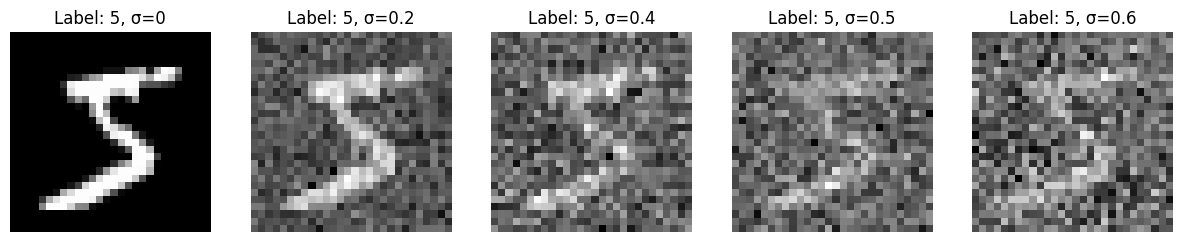

In [ ]:
# Plot 5 images with noise
import os

# Create directory if it doesn't exist
output_dir = './part2_outputs/'
os.makedirs(output_dir, exist_ok=True)

fig, axes = plt.subplots(1, 7, figsize=(21, 3))
sigmas = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
x, y = train_dataset[0]
for i, sigma in enumerate(sigmas):
    
    noisy_x = add_noise(x, sigma=sigma)
    
    axes[i].imshow(noisy_x.squeeze(0), cmap="gray")
    axes[i].set_title(f"Label: {y}, σ={sigma}")
    axes[i].axis("off")

plt.tight_layout()

# Save the figure
output_path = os.path.join(output_dir, '5_noisy_images.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved to {output_path}")

plt.show()

## Part 1.2.1: Training

For this part, we provide some structure code for training. It is very basic, so feel free to change them or add your code. In later section we won't provide any training or visualization structure code.

In [7]:
device = torch.device('cuda')
# Set your hyperparameters
# ===== your code here! ====
batch_size = 256
learning_rate = 1e-4
noise_level = 0.5
hidden_dim = 128
num_epochs = 5
# ===== end of code ====

In [8]:
# Define your datasets and dataloaders
transform = ToTensor()
# ===== your code here! ====
train_dataset = MNIST(root='./data', train=True, download=False, transform=transform) #set download to false after downloaded
test_dataset = MNIST(root='./data', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)
# ===== end of code ====

In [9]:
# Define your model, optimizer, and loss
# ===== your code here! ====
model = UnconditionalUNet(1, hidden_dim)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()
# ===== end of code ====

100%|██████████| 235/235 [00:12<00:00, 19.47it/s]

100%|██████████| 235/235 [00:12<00:00, 19.52it/s]



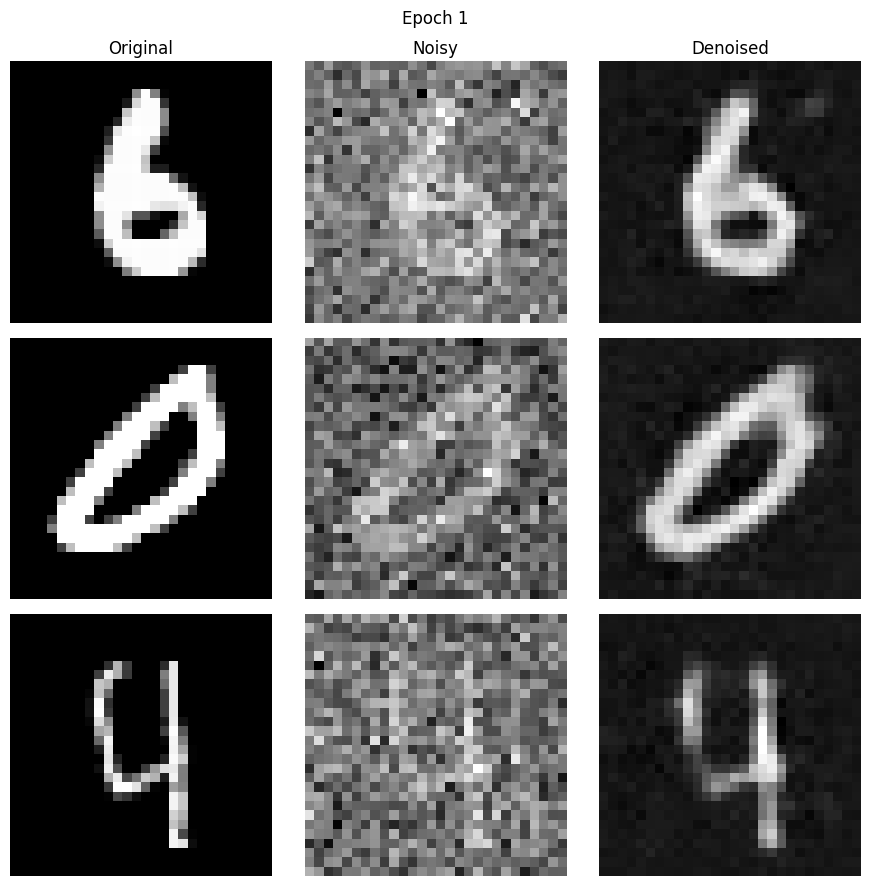

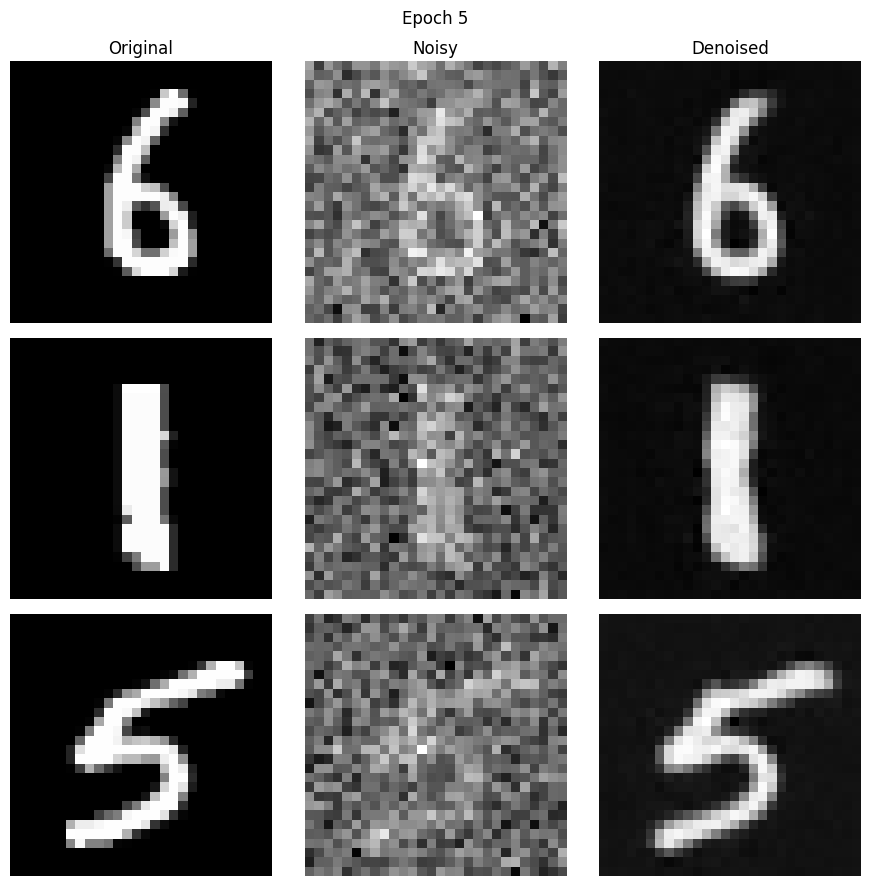

In [27]:
# The training loops
train_losses = []
output_dir = './part2_outputs/full_noise'
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):
        
        # ===== your code here! ===='
        images = images.to(device)
        current_batch_size = images.shape[0]
        noisy_images = add_noise(images, sigma= noise_level)
        #pure_noise = torch.randn(current_batch_size, 1, 28, 28)
        #pure_noise = pure_noise.to(device)
        outputs = model(noisy_images)#need or copy and paste in noisy_images

        # ===== end of code ====

        loss = criterion(outputs, images)
        optimizer.zero_grad()
    
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    
    # Save visualization on epochs 1 and 5
    if epoch + 1 in [1, 5]:
        model.eval()
        with torch.no_grad():
            # Take first 3 images from the first batch
            sample_images = images[:3]
            sample_noisy = noisy_images[:3]
            sample_outputs = outputs[:3]
            
            # Create a 3x3 grid: clean | noisy | denoised
            fig, axes = plt.subplots(3, 3, figsize=(9, 9))
            
            for j in range(3):
                # Clean images
                axes[j, 0].imshow(sample_images[j].cpu().squeeze(0), cmap='gray')
                axes[j, 0].set_title('Original' if j == 0 else '')
                axes[j, 0].axis('off')
                
                # Noisy images
                axes[j, 1].imshow(sample_noisy[j].cpu().squeeze(0), cmap='gray')
                axes[j, 1].set_title('Noisy' if j == 0 else '')
                axes[j, 1].axis('off')
                
                # Denoised outputs
                axes[j, 2].imshow(sample_outputs[j].cpu().squeeze(0), cmap='gray')
                axes[j, 2].set_title('Denoised' if j == 0 else '')
                axes[j, 2].axis('off')
            
            plt.suptitle(f'Epoch {epoch + 1}')
            plt.tight_layout()
            
            # Save the figure
            output_path = os.path.join(output_dir, f'denoising_epoch_{epoch + 1}.png')
            #plt.savefig(output_path, dpi=150, bbox_inches='tight')
            #print(f"Saved to {output_path}")
            #plt.close()
        
        model.train()

Saved to ./part2_outputs/training_loss_curve_unet.png


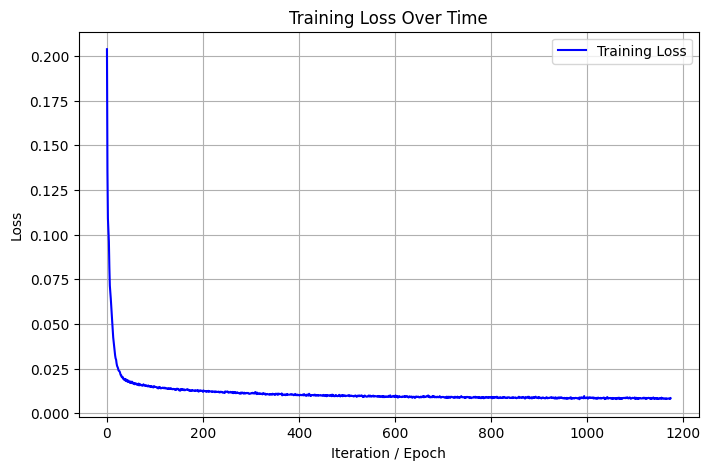

In [13]:
# Visualize your training curve
# ===== your code here! ====
output_dir = './part2_outputs'
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Iteration / Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.legend()

# Save the figure
output_path = os.path.join(output_dir, 'training_loss_curve_unet.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved to {output_path}")

plt.show()
# ===== end of code ====

## Part 1.2.2: Out-of-Distribution Testing

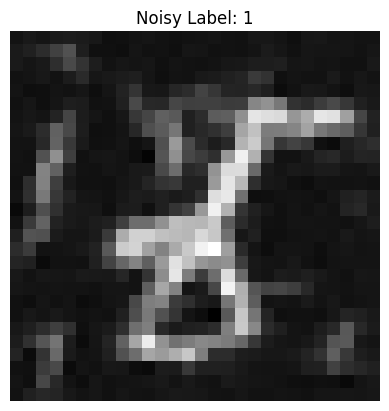

In [31]:
# Visualize OOD testing
# ===== your code here! ====
new_x, y = train_dataset[3]
noisy_x = add_noise(new_x, 1)

with torch.no_grad():
    noisy_x_device = noisy_x.to(device)
    noisy_x_device = noisy_x_device.unsqueeze(0)
    output = model(noisy_x_device).cpu()
    
    plt.imshow(output.squeeze(0).squeeze(0), cmap="gray")
    plt.title(f"Noisy Label: {y}")
    plt.axis("off")
    plt.show()
# ===== end of code ====

Saved to ./part2_outputs/noise_levels_denoising.png


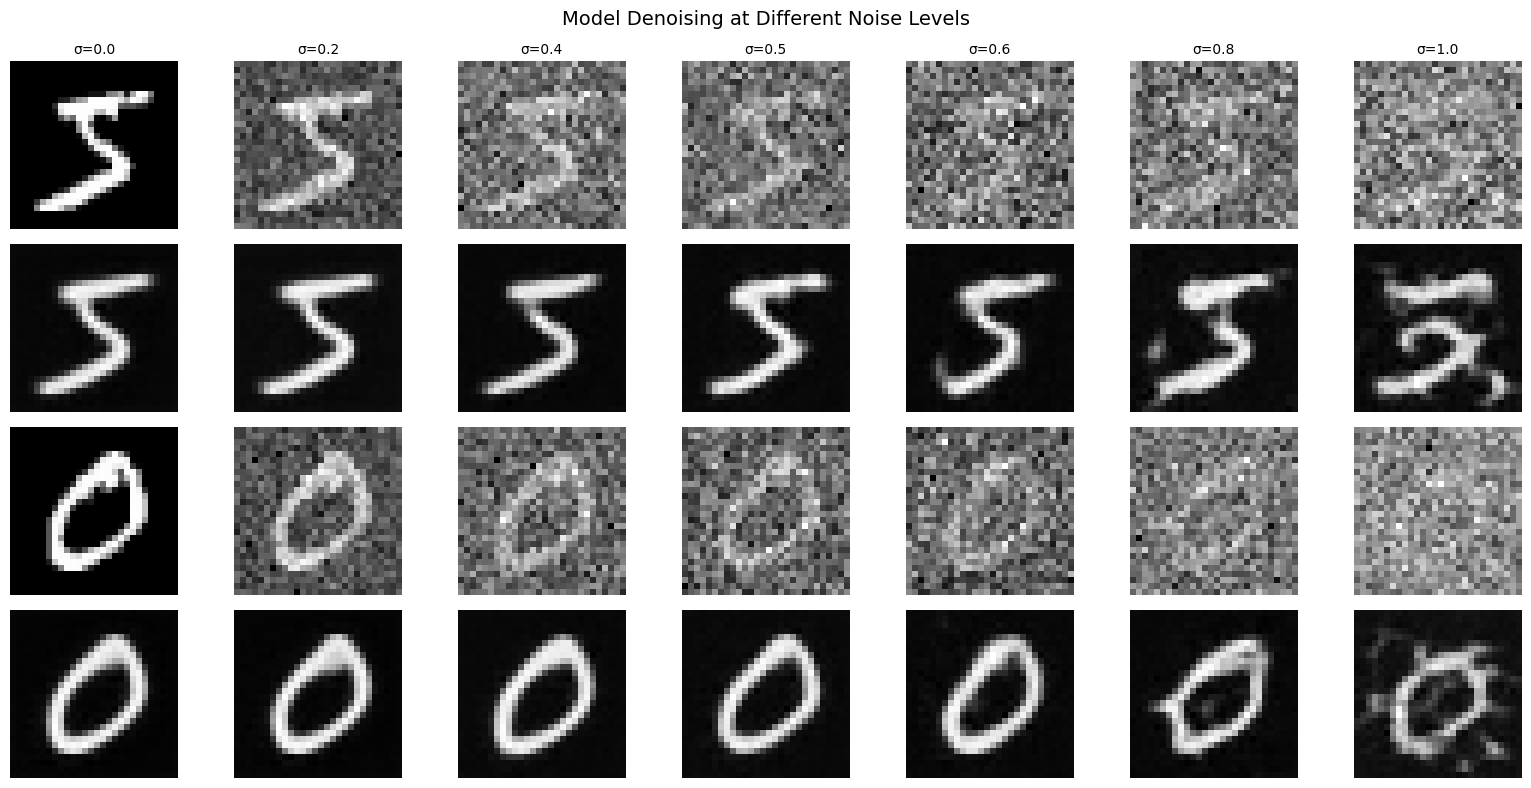

In [29]:
# Visualize samples at different noise levels and their denoised outputs
output_dir = './part2_outputs'
os.makedirs(output_dir, exist_ok=True)

noise_levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
num_samples = 2

# Create figure with num_samples rows and len(noise_levels) columns, with 2 rows per sample (noisy + denoised)
fig, axes = plt.subplots(num_samples * 2, len(noise_levels), figsize=(16, 8))

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        # Get a sample image
        x, y = train_dataset[i]
        x_device = x.to(device).unsqueeze(0)
        
        for j, sigma in enumerate(noise_levels):
            # Add noise
            noisy_x = add_noise(x, sigma=sigma)
            noisy_x_device = noisy_x.to(device).unsqueeze(0)
            
            # Run through model to denoise
            denoised = model(noisy_x_device).cpu()
            
            # Display noisy image (row 2*i)
            axes[2*i, j].imshow(noisy_x.squeeze(0), cmap='gray')
            if j == 0:
                axes[2*i, j].set_ylabel(f'Sample {i+1}\n(Noisy)', fontsize=10)
            if i == 0:
                axes[2*i, j].set_title(f'σ={sigma}', fontsize=10)
            axes[2*i, j].axis('off')
            
            # Display denoised image (row 2*i+1)
            axes[2*i+1, j].imshow(denoised.squeeze(0).squeeze(0), cmap='gray')
            if j == 0:
                axes[2*i+1, j].set_ylabel(f'Sample {i+1}\n(Denoised)', fontsize=10)
            axes[2*i+1, j].axis('off')

plt.suptitle('Model Denoising at Different Noise Levels', fontsize=14)
plt.tight_layout()

# Save the figure
output_path = os.path.join(output_dir, 'noise_levels_denoising.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved to {output_path}")

plt.show()

## Part 1.2.3 Denoising Pure Noise

Not doing this right need to go back and change!

In [33]:
# Define your model, optimizer, and loss
# ===== your code here! ====
model = UnconditionalUNet(1, hidden_dim)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()
# ===== end of code ====

In [34]:
# The training loops
train_losses = []
output_dir = './part2_outputs/full_noise'
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):
        
        # ===== your code here! ===='
        images = images.to(device)
        current_batch_size = images.shape[0]
        #noisy_images = add_noise(images, sigma= noise_level)
        pure_noise = torch.randn(current_batch_size, 1, 28, 28)
        pure_noise = pure_noise.to(device)
        outputs = model(pure_noise)#need or copy and paste in noisy_images

        # ===== end of code ====

        loss = criterion(outputs, images)
        optimizer.zero_grad()
    
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    
    # Save visualization on epochs 1 and 5
    if epoch + 1 in [1, 5]:
        model.eval()
        with torch.no_grad():
            # Take first 3 samples
            sample_noisy = pure_noise[:3]
            sample_outputs = outputs[:3]
            
            # Create a 3x2 grid: pure noise | model output
            fig, axes = plt.subplots(3, 2, figsize=(6, 9))
            
            for j in range(3):
                # Pure noise input
                axes[j, 0].imshow(sample_noisy[j].cpu().squeeze(0), cmap='gray')
                axes[j, 0].set_title('Pure Noise' if j == 0 else '')
                axes[j, 0].axis('off')
                
                # Model output
                axes[j, 1].imshow(sample_outputs[j].cpu().squeeze(0), cmap='gray')
                axes[j, 1].set_title('Model Output' if j == 0 else '')
                axes[j, 1].axis('off')
            
            plt.suptitle(f'Epoch {epoch + 1}')
            plt.tight_layout()
            
            # Save the figure
            output_path = os.path.join(output_dir, f'pure_denoising_epoch_{epoch + 1}.png')
            plt.savefig(output_path, dpi=150, bbox_inches='tight')
            print(f"Saved to {output_path}")
            plt.close()
        
        model.train()

100%|██████████| 235/235 [00:12<00:00, 19.21it/s]



100%|██████████| 235/235 [00:12<00:00, 19.21it/s]



Saved to ./part2_outputs/full_noise/pure_denoising_epoch_1.png


100%|██████████| 235/235 [00:12<00:00, 19.33it/s]



100%|██████████| 235/235 [00:12<00:00, 19.21it/s]



Saved to ./part2_outputs/full_noise/pure_denoising_epoch_1.png


100%|██████████| 235/235 [00:12<00:00, 19.33it/s]



Saved to ./part2_outputs/full_noise/pure_denoising_epoch_5.png


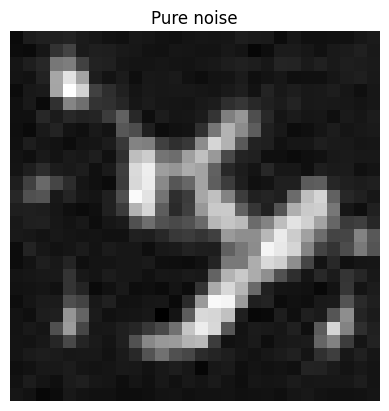

In [12]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====
pure_noise = torch.randn(1, 28, 28)
with torch.no_grad():
    pure_noise = pure_noise.to(device)
    pure_noise = pure_noise.unsqueeze(0)
    output = model(pure_noise).cpu()
    
    plt.imshow(output.squeeze(0).squeeze(0), cmap="gray")
    plt.title(f"Pure noise")
    plt.axis("off")
    plt.show()
# ===== end of code ====

# Part 2: Flow Matching

# Part 2.1: Implementing a Time-conditioned UNet

In [10]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.lin1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.lin2 = nn.Linear(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        f1 = self.lin1(x)
        f1 = self.gelu(f1)
        f1 = self.lin2(f1)
        return f1
        # ===== end of code ====
        raise NotImplementedError()


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        self.convBlock_1 = ConvBlock(in_channels, num_hiddens)
        self.downblock_1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock_2 = DownBlock(num_hiddens, 2 * num_hiddens)

        self.flatten = Flatten()
        self.unflatten = Unflatten(2 * num_hiddens)

        self.FCBlock_1 = FCBlock(1, 2 * num_hiddens)

        self.upblock_1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.FCBlock_2 = FCBlock(1, num_hiddens)
        
        self.upblock_2 = UpBlock(2 * num_hiddens, num_hiddens)

        self.convBlock_2 = ConvBlock(2 * num_hiddens, num_hiddens)
        self.lastConv = nn.Conv2d(num_hiddens, in_channels, 3, 1, 1)
        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,1) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        f1 = self.convBlock_1(x)
        f2 = self.downblock_1(f1)
        f3 = self.downblock_2(f2)

        f4 = self.flatten(f3)
        f5 = self.unflatten(f4)
        
        t1 = self.FCBlock_1(t)
        t1= t1[:, :, None, None]
        f5 *= t1

        concat_bottom = torch.cat((f3, f5), dim=1)
        
        f6 = self.upblock_1(concat_bottom)

        t2 = self.FCBlock_2(t)
        t2= t2[:, :, None, None]
        f6 *= t2

        
        concat_second = torch.cat((f2, f6), dim=1)
        
        f7 = self.upblock_2(concat_second)

        concat_last = torch.cat((f1, f7), dim = 1)
        
        f8 = self.convBlock_2(concat_last)

        final = self.lastConv(f8)

        return final
        # ===== end of code ====
        raise NotImplementedError()

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [11]:
def time_fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====
    device = x_1.device
    B = x_1.shape[0]
    t = torch.randint(0, num_ts, (B,), device=device)
    t = t.float() / num_ts
    t_view = t.view(B, 1, 1, 1)
    x_0 = torch.randn_like(x_1) #sample the noise
    x_t = (1 - t_view) * x_0 + t_view * x_1
    v_target = x_1 - x_0
    v_pred = unet(x_t, t.view(B, 1))
    loss = torch.mean((v_pred - v_target) ** 2)
    return loss
    # ===== end of code ====
    raise NotImplementedError()

In [12]:
@torch.inference_mode()
def time_fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # ===== your code here! ====
    device = next(unet.parameters()).device
    torch.manual_seed(seed)
    H, W = img_wh
    sample_size = 1
    x = torch.randn(sample_size, 1, H, W, device=device)
    ts = torch.linspace(0, 1, num_ts, device=device)
    dt = ts[1] - ts[0]
    for t in ts:
        t_batch = t.expand(sample_size,1).to(device)          # shape (B,1, 1, 1)
        v = unet(x, t_batch)           # velocity
        x = x + dt * v                 # Euler step
    return x
    # ===== end of code ====
    raise NotImplementedError()

In [13]:
class TimeConditionalFM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return time_fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return time_fm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


# Part 2.2: Training the Time-conditioned UNet

In [15]:
device = torch.device('cuda')
# Set your hyperparameters
# ===== your code here! ====
batch_size = 64
learning_rate = 1e-2
hidden_dim = 64
num_epochs = 10
# ===== end of code ====

unet = TimeConditionalUNet(in_channels=1, num_classes=0, num_hiddens=hidden_dim) #correct this!
model = TimeConditionalFM(unet=unet)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
gamma_val = 0.1 ** (1.0/num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma_val)



In [16]:
train_losses = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):

        images = images.to(device)

        # Compute FM loss directly
        loss = model(images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        train_losses.append(loss.item())
    scheduler.step()

    # Save model checkpoints at epochs 1, 5, and 10
    if epoch + 1 in [1, 5, 10]:
        import os
        # ensure checkpoint dir exists
        ckpt_dir = './part2_outputs/time_fm_checkpoints'
        os.makedirs(ckpt_dir, exist_ok=True)

        # Save both model and optimizer state dicts so training can be resumed
        ckpt = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
        }
        ckpt_path = os.path.join(ckpt_dir, f'time_fm_epoch_{epoch + 1}.pt')
        try:
            torch.save(ckpt, ckpt_path)
            print(f"Saved checkpoint to {ckpt_path}")
        except Exception as e:
            print(f"Failed to save checkpoint to {ckpt_path}: {e}")

100%|██████████| 235/235 [00:06<00:00, 35.32it/s]


Saved checkpoint to ./part2_outputs/time_fm_checkpoints/time_fm_epoch_1.pt


100%|██████████| 235/235 [00:06<00:00, 37.80it/s]


Saved checkpoint to ./part2_outputs/time_fm_checkpoints/time_fm_epoch_5.pt


100%|██████████| 235/235 [00:06<00:00, 37.73it/s]


Saved checkpoint to ./part2_outputs/time_fm_checkpoints/time_fm_epoch_10.pt


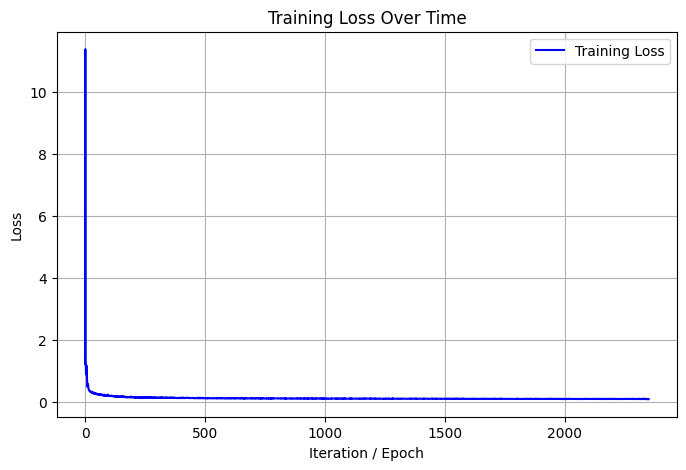

In [17]:
# Visualize your training curve
# ===== your code here! ====
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Iteration / Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.legend()
plt.show()
# ===== end of code ====

# Part 2.3: Sampling from the Time-conditioned UNet

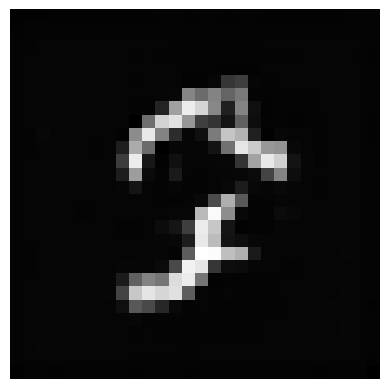

In [18]:
# Sampling from the UNet
# ===== your code here! ====
img_wh = (28, 28)      # or whatever your dataset/image size is 
seed = 0                # optional for reproducibility
with torch.no_grad():
    sample = model.sample(img_wh=img_wh, seed=seed)

    img = sample[0, 0].cpu().numpy()   # single-channel
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    # ===== end of code ====


Loading checkpoint from epoch 1...
Loaded model from epoch 1
Saved sample grid to ./part2_outputs/time_fm_samples_epoch_1.png


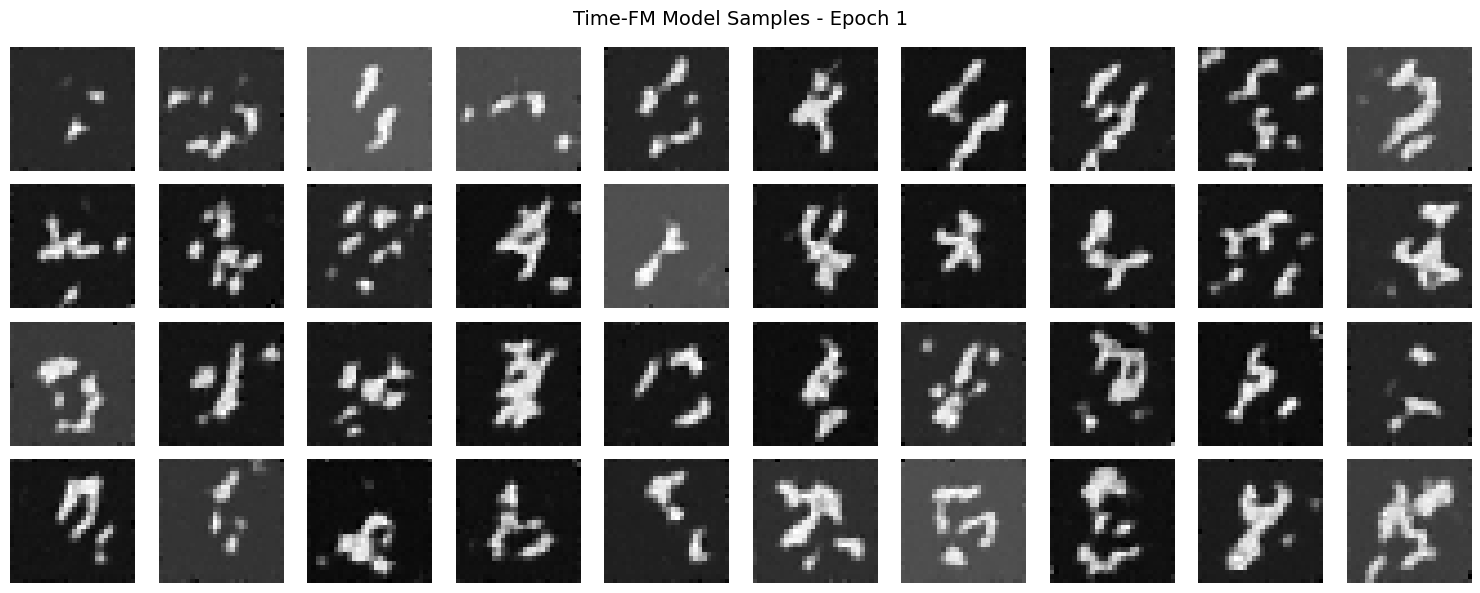


Loading checkpoint from epoch 5...
Loaded model from epoch 5
Saved sample grid to ./part2_outputs/time_fm_samples_epoch_5.png


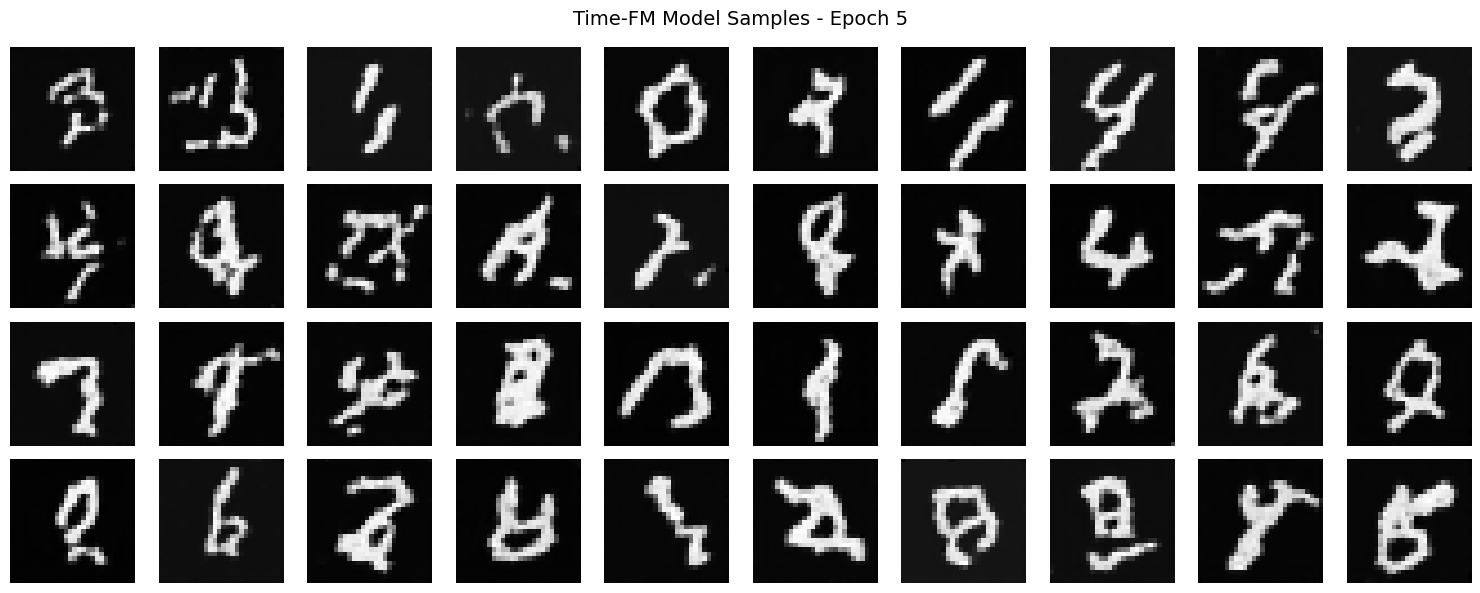


Loading checkpoint from epoch 10...
Loaded model from epoch 10
Saved sample grid to ./part2_outputs/time_fm_samples_epoch_10.png


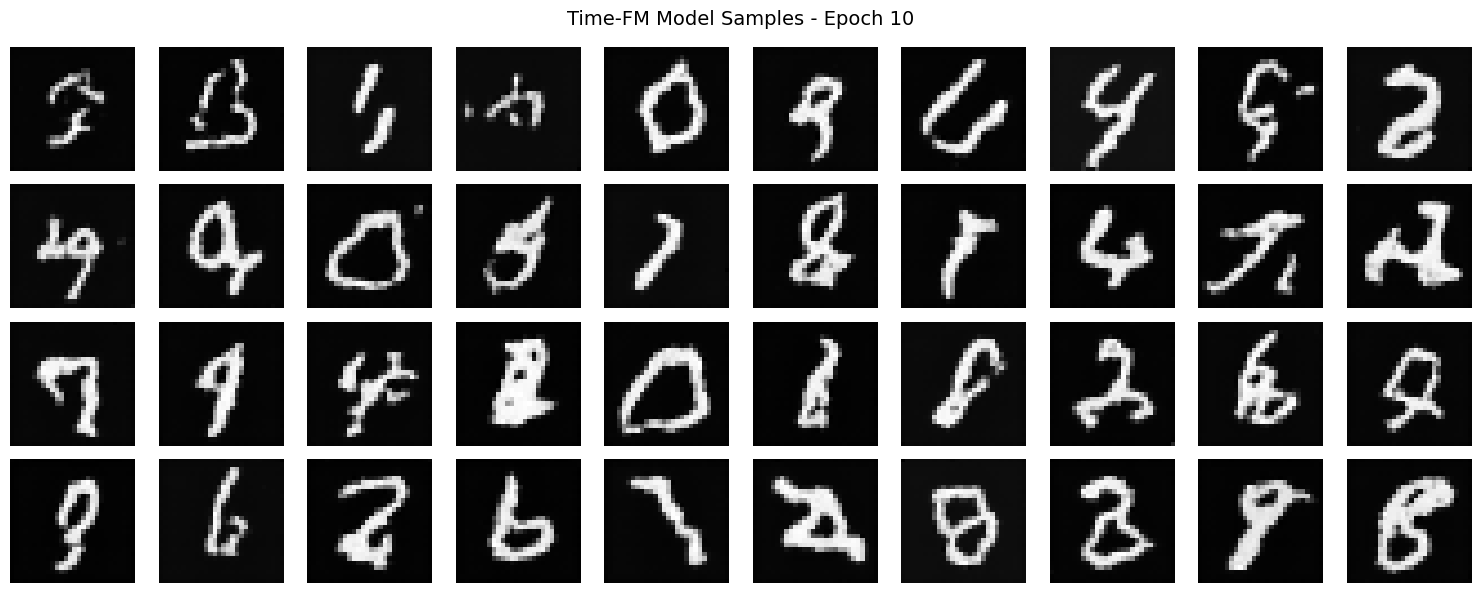


Done sampling from all checkpoints!


In [20]:
# Load checkpoints and generate 40 samples from each (epochs 1, 5, 10)
import os

ckpt_dir = './part2_outputs/time_fm_checkpoints'
output_dir = './part2_outputs'
os.makedirs(output_dir, exist_ok=True)

# Epochs to load
epochs_to_sample = [1, 5, 10]
num_samples_per_epoch = 40
grid_rows, grid_cols = 4, 10

for target_epoch in epochs_to_sample:
    ckpt_path = os.path.join(ckpt_dir, f'time_fm_epoch_{target_epoch}.pt')
    
    if not os.path.exists(ckpt_path):
        print(f"Checkpoint not found: {ckpt_path}")
        continue
    
    print(f"\nLoading checkpoint from epoch {target_epoch}...")
    
    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    
    # Restore model state
    model.load_state_dict(ckpt['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Loaded model from epoch {target_epoch}")
    
    # Generate 40 samples
    all_samples = []
    with torch.no_grad():
        for seed in range(num_samples_per_epoch):
            sample = model.sample(img_wh=(28, 28), seed=seed)
            all_samples.append(sample[0, 0].cpu().numpy())
    
    all_samples = np.array(all_samples)  # (40, 28, 28)
    
    # Create 4x10 grid
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 6))
    
    for idx, ax in enumerate(axes.flat):
        ax.imshow(all_samples[idx], cmap='gray')
        ax.axis('off')
    
    plt.suptitle(f'Time-FM Model Samples - Epoch {target_epoch}', fontsize=14)
    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(output_dir, f'time_fm_samples_epoch_{target_epoch}.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved sample grid to {save_path}")
    
    plt.show()
    plt.close()

print("\nDone sampling from all checkpoints!")


# Part 2.4: Implementing a Class-conditioned UNet

In [22]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        self.convBlock_1 = ConvBlock(in_channels, num_hiddens)
        self.downblock_1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock_2 = DownBlock(num_hiddens, 2 * num_hiddens)

        self.flatten = Flatten()
        self.unflatten = Unflatten(2 * num_hiddens)

        self.FCBlock_1 = FCBlock(1, 2 * num_hiddens)
        self.FCBlock_c1 = FCBlock(num_classes, 2 * num_hiddens) #the dimension is 10 now because we are one hot encoding 0-9

        self.upblock_1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.FCBlock_2 = FCBlock(1, num_hiddens)
        self.FCBlock_c2 = FCBlock(num_classes, num_hiddens)
        
        self.upblock_2 = UpBlock(2 * num_hiddens, num_hiddens)

        self.convBlock_2 = ConvBlock(2 * num_hiddens, num_hiddens)
        self.lastConv = nn.Conv2d(num_hiddens, in_channels, 3, 1, 1)  
        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        f1 = self.convBlock_1(x)
        f2 = self.downblock_1(f1)
        f3 = self.downblock_2(f2)

        f4 = self.flatten(f3)
        f5 = self.unflatten(f4)
        t1 = self.FCBlock_1(t)
        t1 = t1[:,:, None, None]
        c1 = self.FCBlock_c1(c)
        c1 = c1[:,:, None, None]
        
        
        f5 = f5*c1 + t1

        concat_bottom = torch.cat((f3, f5), dim=1)
        
        f6 = self.upblock_1(concat_bottom)

        t2 = self.FCBlock_2(t)
        t2 = t2[:, :, None, None]

        c2 = self.FCBlock_c2(c)
        c2 = c2[:, :, None, None]

        f6 = f6*c2 + t2

        
        concat_second = torch.cat((f2, f6), dim=1)
        
        f7 = self.upblock_2(concat_second)

        concat_last = torch.cat((f1, f7), dim = 1)
        
        f8 = self.convBlock_2(concat_last)

        final = self.lastConv(f8)

        return final
        # ===== end of code ====
        raise NotImplementedError()

In [23]:
def class_fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====
    device = x_1.device
    
    B = x_1.shape[0]
    one_hot = nn.functional.one_hot(c, num_classes=10).float().to(device)
    mask = torch.bernoulli(torch.full((B, 10), 1 - p_uncond, device=device)) #remember to have the number of classes for the mask!
    one_hot = one_hot * mask

    t = torch.randint(0, num_ts, (B,), device=device)
    t = t.float() / num_ts
    t_view = t.view(B, 1, 1, 1)
    x_0 = torch.randn_like(x_1) #sample the noise
    x_t = (1 - t_view) * x_0 + t_view * x_1
    v_target = x_1 - x_0
    v_pred = unet(x_t, c= one_hot, t = t.view(B, 1))
    loss = torch.mean((v_pred - v_target) ** 2)
    return loss
    # ===== end of code ====
    raise NotImplementedError()

In [24]:
@torch.inference_mode()
def class_fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # ===== your code here! ====
    device = next(unet.parameters()).device
    sample_size = c.shape[0]
    torch.manual_seed(seed)

    ts = torch.linspace(0, 1, steps=num_ts, device=device)
    dt = ts[1] - ts[0]
    H, W = img_wh
    sample_size = 1
    x = torch.randn(sample_size, 1, H, W, device=device)

    one_hot = nn.functional.one_hot(c, num_classes=10).float().to(device)
    zeros_vec = torch.zeros_like(one_hot).to(device)
    for t in ts:
        t_batch = t.expand(sample_size,1).to(device)   
        u_uncond = unet(x, zeros_vec, t_batch)
        u_cond = unet(x, one_hot, t_batch)
        u = u_uncond + guidance_scale * (u_cond - u_uncond)
        x = x + dt * u
    return x
    # ===== end of code ====
    raise NotImplementedError()

In [25]:
class ClassConditionalFM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return class_fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return class_fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

# Part 2.5 Training the Class-conditioned UNet

In [37]:
device = torch.device('cuda')
# Set your hyperparameters
# ===== your code here! ====
batch_size = 128
learning_rate = 1e-2
hidden_dim = 64
num_epochs = 10
# ===== end of code ====

unet = ClassConditionalUNet(in_channels = 1, num_classes=10, num_hiddens = hidden_dim)
model = ClassConditionalFM(unet)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
gamma_val = 0.1 ** (1.0/num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma_val)

In [38]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====
train_losses = []

for epoch in range(num_epochs):
    for i, (images, c) in enumerate(tqdm(train_loader)):

        images = images.to(device)

        # Compute FM loss directly
        loss = model(images, c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        train_losses.append(loss.item())
    #scheduler.step()

    # Save model checkpoints at epochs 1, 5, and 10
    if epoch + 1 in [1, 5, 10]:
        import os
        # ensure checkpoint dir exists
        ckpt_dir = './part2_outputs/wo_scheduler'
        os.makedirs(ckpt_dir, exist_ok=True)

        # Save both model and optimizer state dicts so training can be resumed
        ckpt = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
        }
        ckpt_path = os.path.join(ckpt_dir, f'cfg_epoch_{epoch + 1}.pt')
        try:
            torch.save(ckpt, ckpt_path)
            print(f"Saved checkpoint to {ckpt_path}")
        except Exception as e:
            print(f"Failed to save checkpoint to {ckpt_path}: {e}")

# ===== end of code ====

100%|██████████| 235/235 [00:06<00:00, 36.41it/s]


Saved checkpoint to ./part2_outputs/wo_scheduler/cfg_epoch_1.pt


100%|██████████| 235/235 [00:06<00:00, 37.26it/s]


Saved checkpoint to ./part2_outputs/wo_scheduler/cfg_epoch_5.pt


100%|██████████| 235/235 [00:06<00:00, 37.10it/s]


Saved checkpoint to ./part2_outputs/wo_scheduler/cfg_epoch_10.pt


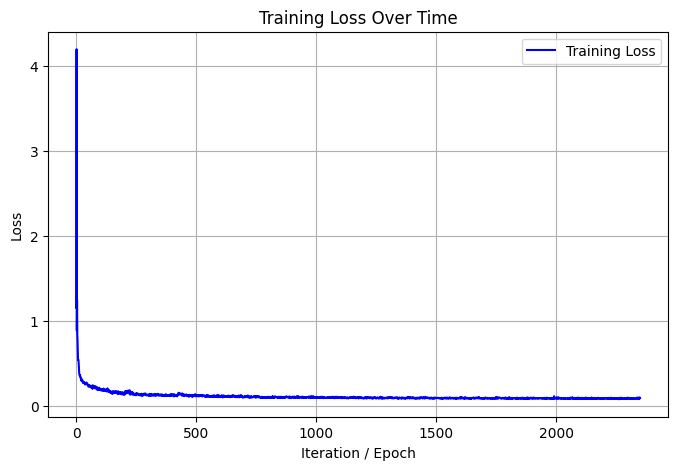

In [39]:
# Visualize your training curve
# ===== your code here! ====
output_dir = './part2_outputs/cfg_checkpoints'
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Iteration / Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.legend()

# Save the figure
output_path = os.path.join(output_dir, 'training_loss_curve_cfg.png')
#plt.savefig(output_path, dpi=150, bbox_inches='tight')
#print(f"Saved to {output_path}")

plt.show()
# ===== end of code ====

# Part 2.6: Sampling from the Class-conditioned UNet

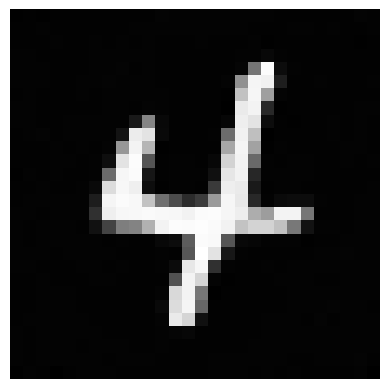

In [40]:
# Sampling from the UNet
# ===== your code here! ====
img_wh = (28, 28)      # or whatever your dataset/image size is 
seed = 0                # optional for reproducibility
c = torch.tensor([4], device=device)
with torch.no_grad():
    sample = model.sample(c = c, img_wh=img_wh, seed=seed)

    img = sample[0, 0].cpu().numpy()   # single-channel
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
# ===== end of code ====


Loading checkpoint from epoch 1...
Loaded model from epoch 1
Saved sample grid to ./part2_outputs/wo_scheduler/cfg_samples_epoch_1.png


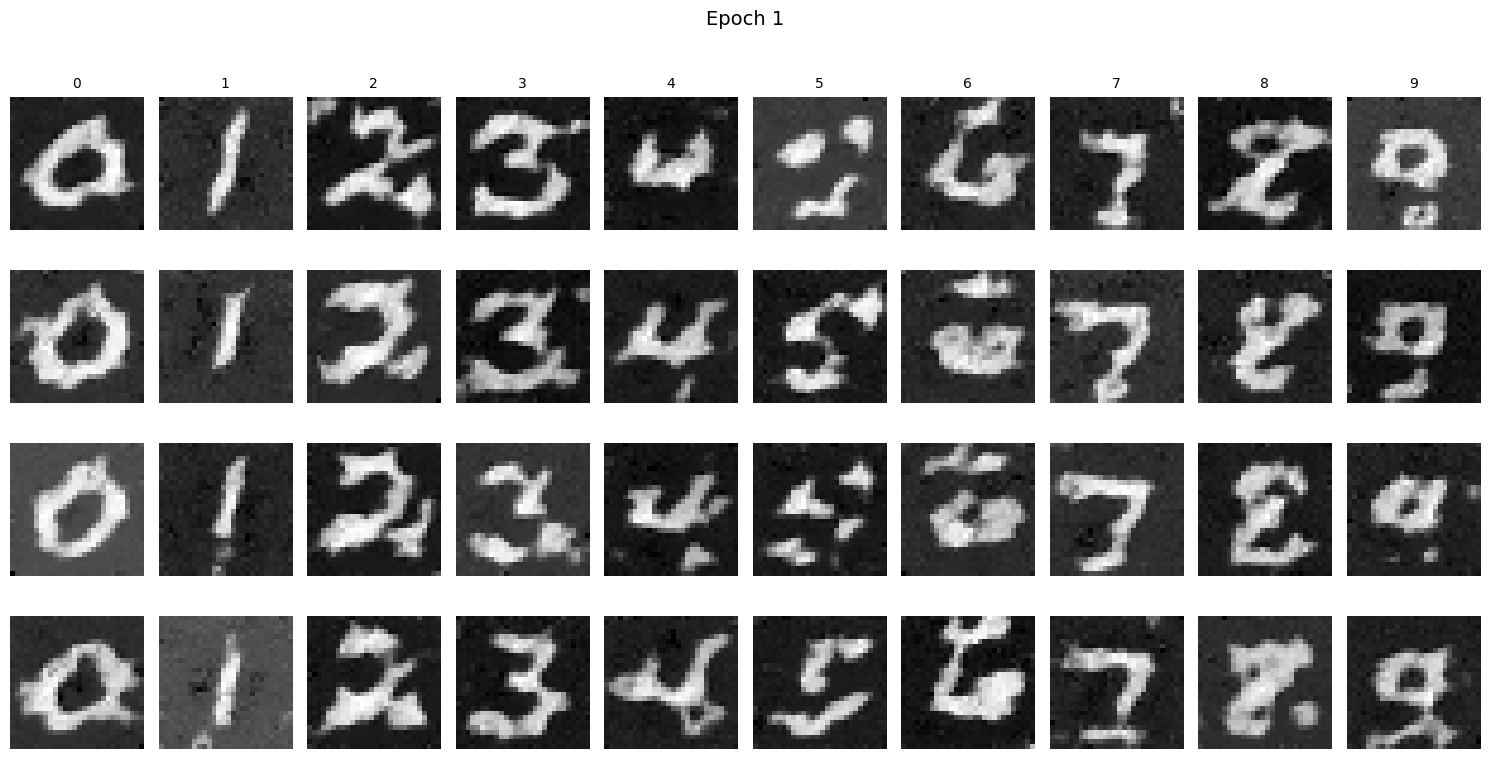


Loading checkpoint from epoch 5...
Loaded model from epoch 5
Saved sample grid to ./part2_outputs/wo_scheduler/cfg_samples_epoch_5.png


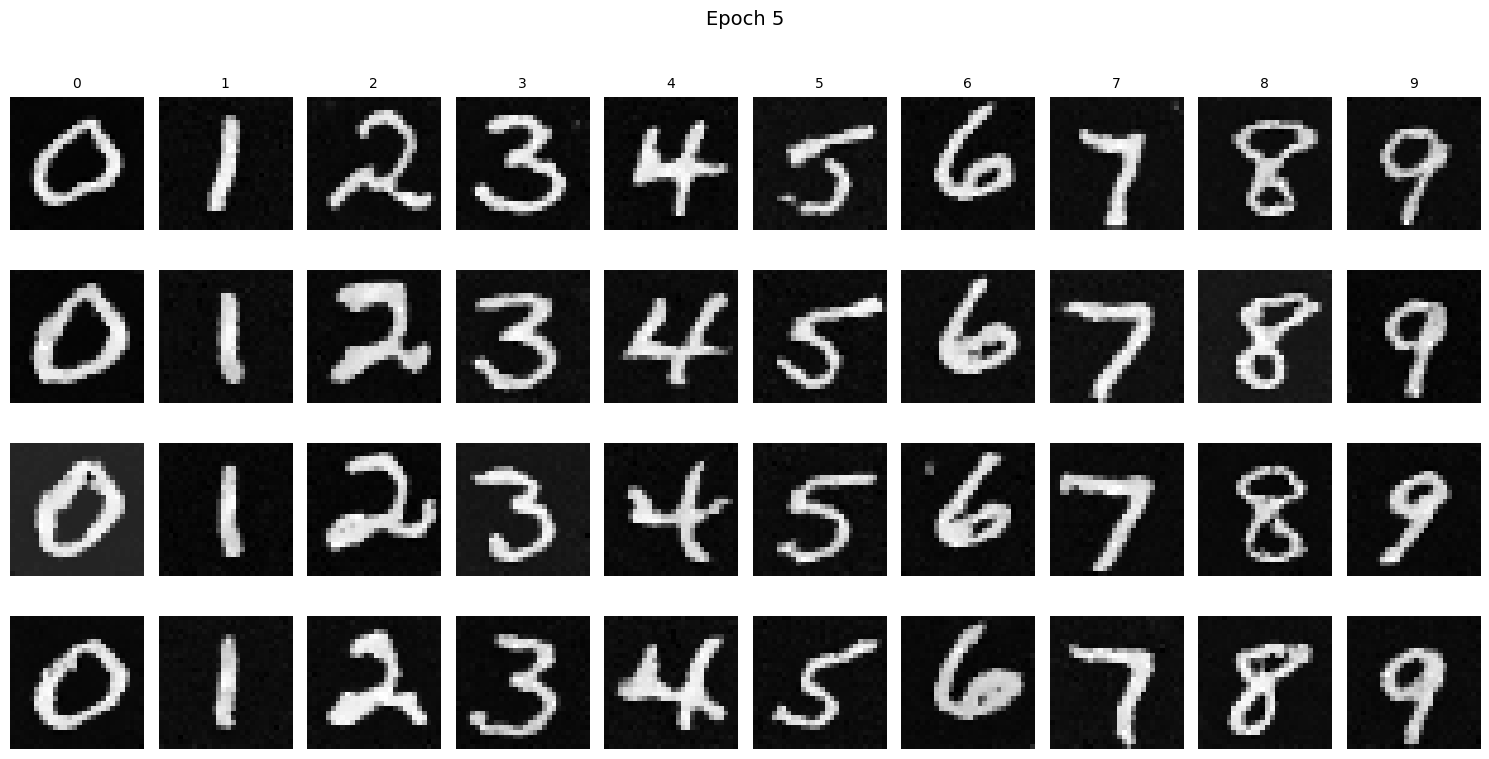


Loading checkpoint from epoch 10...
Loaded model from epoch 10
Saved sample grid to ./part2_outputs/wo_scheduler/cfg_samples_epoch_10.png


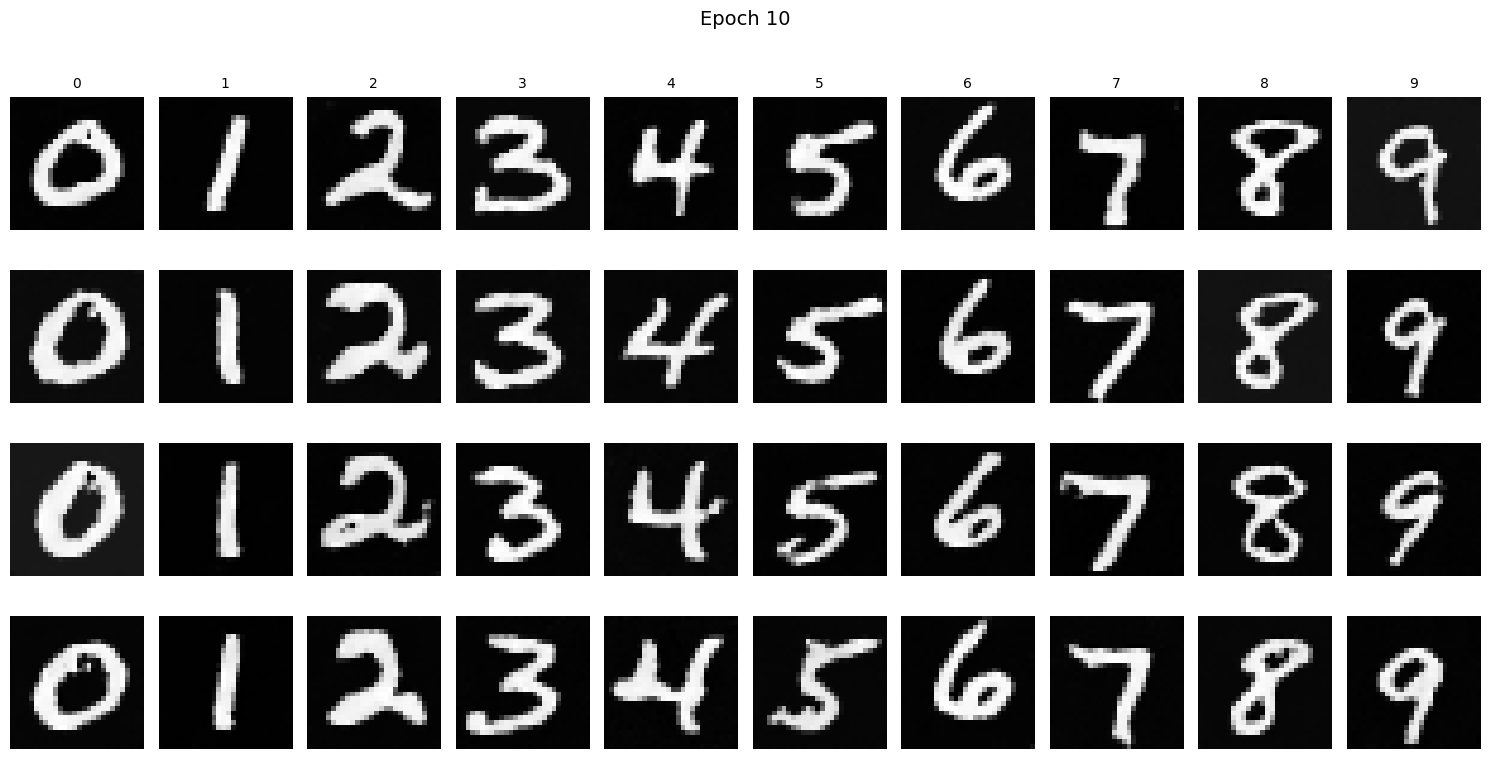


Done sampling from all class-conditional checkpoints!


In [41]:
# Sample 4 images of each digit (0-9) from each cfg_epoch checkpoint
import os

ckpt_dir = './part2_outputs/wo_scheduler'
output_dir = './part2_outputs/wo_scheduler'
os.makedirs(output_dir, exist_ok=True)

# Epochs to sample from
epochs_to_sample = [1, 5, 10]
num_digits = 10
samples_per_digit = 4

for target_epoch in epochs_to_sample:
    ckpt_path = os.path.join(ckpt_dir, f'cfg_epoch_{target_epoch}.pt')
    
    if not os.path.exists(ckpt_path):
        print(f"Checkpoint not found: {ckpt_path}")
        continue
    
    print(f"\nLoading checkpoint from epoch {target_epoch}...")
    
    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    
    # Restore model state
    model.load_state_dict(ckpt['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Loaded model from epoch {target_epoch}")
    
    # Create figure with 4 rows and 10 columns (4 samples per digit, digits 0-9)
    fig, axes = plt.subplots(samples_per_digit, num_digits, figsize=(15, 8))
    
    # Generate samples organized by digit
    all_samples_by_digit = {digit: [] for digit in range(num_digits)}
    
    with torch.no_grad():
        for digit in range(num_digits):
            for sample_idx in range(samples_per_digit):
                c = torch.tensor([digit], device=device)
                seed = digit * samples_per_digit + sample_idx
                sample = model.sample(c=c, img_wh=(28, 28), seed=seed, guidance_scale=5.0)
                all_samples_by_digit[digit].append(sample[0, 0].cpu().numpy())
    
    # Plot samples in 4x10 grid (4 rows, 10 columns for digits 0-9)
    for row in range(samples_per_digit):
        for col in range(num_digits):
            ax = axes[row, col]
            ax.imshow(all_samples_by_digit[col][row], cmap='gray')
            if row == 0:
                ax.set_title(f'{col}', fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'Epoch {target_epoch}\n', fontsize=14)
    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(output_dir, f'cfg_samples_epoch_{target_epoch}.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved sample grid to {save_path}")
    
    plt.show()
    plt.close()

print("\nDone sampling from all class-conditional checkpoints!")